## Inicjalizacja środowiska programistycznego

In [ ]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

import os
os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

Dane w postaci pary macierzy `x,y` są mało wydajne w sytuacji gdy jest ich dużo lub są rozmieszczone w wielu plikach.
TF dostarcza dedykowaną klasę do obsługi strumienia wejścia:
```Python
tf.data.Dataset(variant_tensor)
```

Klasa `tf.Dataset` pozwala na zaawansowane operacje na danych. Implementacja tych operacji korzysta równoległego przetwarzania danych w celu zwiększenia przepustowości strumienia wejścia: `liczby przykładów na sekundę`.



Obiekt `tf.Dataset` można tworzyć na wiele sposobów:

* z macierzy:

```Python
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
```

* z funkcji typu generator

```Python
dataset = tf.data.Dataset.from_generator(...)
```

* z pliku typu CSV

```Python
dataset = tf.data.TextLineDataset(...)
```

* z pliku zawierającego dane w dedykowanym formacie `TFRecord`

```Python
dataset = tf.data.TFRecordDataset(["file1.tfrecords", "file2.tfrecords"])
```



Konstrukcja `tf.data.Dataset` z macierzy NumPy

In [ ]:
nExamples = 5
nFeatures = 3
epsilon = 0.01
x = tf.random.uniform((nExamples, nFeatures), minval=-1, maxval=1, dtype=tf.float32, name="features")
y = tf.math.reduce_sum(x**2, axis=1)
y = tf.reshape(y, (-1, 1))

print(colored("Features shape:", "blue"), x.shape)
print(colored("Labels shape:", "blue"), y.shape)

dataset = tf.data.Dataset.from_tensor_slices((x, y))
print(dataset)
print(colored("Dataset lenght:", "blue"), len(dataset))

`tf.Dataset` zachowuje się jak kolekcja - można po niej iterować łatwo dostosowując liczbę analizowanych elementów i punkt startowy:

In [ ]:
print(colored("Iteration over the full dataset", "blue"))
for item in dataset:
    print(item)

print(colored("Iteration over n elements", "blue"))
n = 3
for item in dataset.take(n):
    print(item)

print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item)    

Konstrukcja `tf.Dataset` z funkcji generującej.

W tym wypadku oprócz funkcji generującej musimy podać informacje o kształcie i typie danych generowanych przez funkcję:
```Python
dataset = tf.data.Dataset.from_generator(
         generator,                                      # funkcja generująca
         output_signature=(                              # opis kształtu i typu
             (tf.TensorSpec(shape=(3), dtype=tf.float32),# danych generowanych
             tf.TensorSpec(shape=(1), dtype=tf.int32)))  # przez funkcję
    )
```

In [34]:
#Generator function definition
nFeatures = 3

def points3DGenerator():
    while True:
        x = tf.random.uniform(shape=(nFeatures,), minval=-1, maxval=1, dtype=tf.float32, name="features")
        y = tf.math.reduce_sum(x**2, axis=0)
        y = tf.reshape(y, (1))
        yield x,y

#Dataset from generator
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )


In [ ]:
print(colored("Iteration over n elements starting from m", "blue"))
n = 3
m = 2
for item in dataset.skip(m).take(n):
    print(item) 

Na zbiorze `tf.Dataset` można wykonywać różne operacje przekształcenia:

```Python
dataset = dataset.repeat(n) - # powtarza dane n razy
                              # W sytuacji gdy nie podano argumentu
                              # dane są powtarzane w nieskończoność.
```

**Uwaga:** nie trzeba używać `repeat` by uzyskać wiele epok w czasie treningu. Funkcja `model.fit(...)` 
sama zarządza wielokrotnymi przejściami przez zbiór danych

```Python
dataset = dataset.batch(n)   - # grupowanie zbioru w paczki. 
                               # W czasie treningu paczki są automatycznie 
                               # rozpoznane i nie trzeba (nie wolno) podawać 
                               # rozmiaru paczki explicite. 
```

```Python
dataset = dataset.skip(m)    - # opuszcza pierwsze m przykładów
                              
```

```Python
dataset = dataset.take(n)    - # ogranicza zbiór do pierwszych n przykładów
                              
```

```Python
dataset = dataset.skip(m).take(n)    - # opuszcza pierwsze m, i bierze 
                                       # kolejne n przykładów
                              
```

In [ ]:
dataset_batched = dataset.batch(2)

#Access a single example (batch in this case)
it = iter(dataset_batched)
print(colored("Features shape:", "blue"), next(it)[0].numpy().shape)
print(colored("Labels shape:", "blue"), next(it)[1].numpy().shape)

print(colored("Iteration over n elements starting from m", "blue"))
m = 5
n = 1
for item in dataset_batched.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

Zbiór danych można poddać też ogólnej transformacji zmieniającej zawartość poszczególnych wierszy:
```Python
dataset_transformed = dataset.map(func) # func to funkcja przyjmująca dany wiersz i zwracająca nowy
```

In [ ]:
def func(features, label):
    return features**2, label

dataset_transformed = dataset.map(func)

print(colored("Iteration over original dataset", "blue"))
for item in dataset.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

print(colored("Iteration over transformed dataset", "blue"))
for item in dataset_transformed.skip(m).take(n):
    print(colored("\tLabels:","blue"),item[0].numpy())
    print(colored("\tFeatures:","blue"),item[1].numpy())

**Proszę:**

* skopiować funkcję `discGenerator` z poprzednich zajęć
* stworzyć zbiór `tf.Dataset` obrazów kół korzystając bezpośrednio z generatora. Proszę przyjąć rozdzielczość 256 $\times$ 256

In [ ]:
def discGenerator(res=256):

    from skimage.draw import disk
    while True:
        center = tf.random.uniform([2], minval=0, maxval = res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval = res//2, dtype=tf.int32, name='radius')        
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx,yy] = 1
        features = tf.concat(values=(center, radius), axis=0 )
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield  features, label

#BEGIN_SOLUTION
res = 256
dataset = tf.data.Dataset.from_generator(discGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(3), dtype=tf.int32),
             tf.TensorSpec(shape=(res,res,1), dtype=tf.int32)))
    )
#END_SOLUTION

item = next(iter(dataset))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

**Proszę:**

* napisać funkcję `reading_benchmark(dataset)` która przyjmuje zbiór danych, iteruje po całym zbiorze i oblicza i 
   wypisuje na ekran swój czas wykonania
* w iteracjach po elementach zbioru proszę wstawić krótki postój:
```Python
time.sleep(1E-10)
```
* proszę wywołać funkcję na zbiorze który ma $10^{4}$ elementów i zarejestrować czas przebiegu po zbiorze

In [ ]:
import time

def reading_benchmark(dataset):
#BEGIN_SOLUTION 
    start_time = time.perf_counter()
    for sample in dataset:
        # Performing a training step
        time.sleep(1E-10)
    tf.print("Execution time: {:3.2f} s".format(time.perf_counter() - start_time))


reading_benchmark(dataset.take(int(1E4)))    
#END_SOLUTION    
pass

Generacja danych za każdym razem kiedy jest wywoływana iteracja po zbiorze jest kosztowana - 
lepiej wygenerować dane raz i je zapisać w pamięci podręcznej. To samo dotyczy zbiorów czytanych z dysku i 
poddawanych kosztownym operacjom przekształcania. Zapisywanie zbioru w tymczasowym pliku można uzyskać przez metodę `cache`:
```Python
dataset_cached = dataset.cache()
```

**Proszę:**

* wywołać dwa razy funkcję `reading_benchmark` na zbiorze `dataset_cached`
* czy jest jakaś różnica w czasie wykonania?
* jeśli tak, to skąd się ona bierze?

In [ ]:
#BEGIN_SOLUTION
dataset_cached = dataset.take(int(1E4)).cache()

print(colored("First pass", "blue"))
reading_benchmark(dataset_cached)
print(colored("Second pass", "blue"))
reading_benchmark(dataset_cached)
#END_SOLUTION

Każdy wiersz danych w postaci `tf.Dataset` powinien zawierać cechy i etykiety by można go było przekazać do funkcji trenującej model:
```Python
model.fit(dataset, ...)  #Podajemy tylko tf.Dataset. 
                         #Metoda model.fit(...) sama rozkłada każdy wiersz na cechy i etykiety
```

Jeśli `tf.Dataset` pochodzi z generatora, jako dane walidacyjne najlepiej podać nowy zbiór. 
W tej sytuacji trzeba także podać liczbę przykładów dla obu zbiorów:

```Python
model.fit(dataset.batch(batchSize).take(nStepsPerEpoch),
          epochs=nEpochs, 
          validation_data=dataset.batch(batchSize).map(mapFunc).take(100))
```

**Proszę:**

* wytrenować **minimalny** model obliczający kwadrat odległości punktu od środka układu współrzędnych
* jako zbiorów uczacego, walidacyjnego i testowego proszę użyć obiektów `tf.Dataset` wypełnionych z użyciem generatora `points3DGenerator(...)`
* użyć funkcji przekształcającej etykietę do wymaganej postaci z użyciem `tf.Dataset.map(...)`
* przyjąć następujące parametry treningu:
```Python
nEpochs = 5
nStepsPerEpoch = 4096
batchSize = 32
initial_learning_rate = 5E-2
```
* narysować historię treningu
* wypisać wagi modelu w sposób pozwalający na interpretację
* obliczyć ułamek przykładów ze zbioru testowego dla którego wynik modelu różni się od etykiety o nie więcej niż 1%

**Wskazówka:**
wartości etykiet można wydobyć w następujący (suboptymalny) sposób:
```Python
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])
```

**Uwaga:** trening powinien zająć około 3'

Czy wynik na zbiorze testowym jest zgodny z oczekiwaniem?

1) Przygotowanie danych z generatora.

In [35]:
##BEGIN_SOLUTION
dataset = tf.data.Dataset.from_generator(points3DGenerator,
         output_signature=(
             (tf.TensorSpec(shape=(nFeatures,), dtype=tf.float32, name="features"),
             tf.TensorSpec(shape=(1), dtype=tf.float32, name="labels")))
    )
##END_SOLUTION
item = next(iter(dataset))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (3,)
Labels shape: (1,)


2) przygotowanie danych

* podział na paczki
* modyfikacja zawartości danych z użyciem `dataset.map(...)`.
* przygotowanie odpowiedniej liczby przykładów
* buforowanie


In [36]:
#BEGIN_SOLUTION
nStepsPerEpoch = 4096
batchSize = 64
dataset_cached = dataset.batch(batchSize).map(func).take(nStepsPerEpoch).cache()
#END_SOLUTION

item = next(iter(dataset_cached))
print(colored("Features shape:", "blue"), item[0].shape)
print(colored("Labels shape:", "blue"), item[1].shape)

Features shape: (64, 3)
Labels shape: (64, 1)


2024-05-08 14:40:05.459757: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3) definicja modelu

In [37]:
#BEGIN_SOLUTION
def getModel(inputShape, nNeurons, hiddenActivation="relu", outputActivation="linear", nOutputNeurons=1):
   
    inputs = tf.keras.Input(shape=inputShape, name="features")
    x = inputs
    
    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation, 
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                                  name="layer_"+str(iLayer))(x)
                
    outputs = tf.keras.layers.Dense(nOutputNeurons, activation=outputActivation, name = "output")(x)   
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DNN")
    return model

model = getModel(inputShape=(nFeatures,), nNeurons = np.array([]), 
                 hiddenActivation="relu", 
                 outputActivation="linear", 
                 nOutputNeurons=1)
#END_SOLUTION
model.summary()

Model: "DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

4) trening ze wszystkimi standardowymi elementami:
* harmonogram współczynnika uczenia
* wczesne zatrzymanie
* wykres zmiany funkcji straty

Epoch 1/5


   3840/Unknown 183s 45ms/step - loss: 4.9557

2024-05-08 14:43:46.028903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:46.028938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 184s 45ms/step - loss: 4.9552 - val_loss: 0.2499
Epoch 2/5
 279/3840 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - loss: 4.4426

2024-05-08 14:43:46.232158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:46.232193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 542us/step - loss: 2.6861 - val_loss: 1.2222
Epoch 3/5
 103/3840 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - loss: 2.8279

2024-05-08 14:43:48.194314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:48.194338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-08 14:43:48.318239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:48.318261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 512us/step - loss: 2.8731 - val_loss: 1.3380
Epoch 4/5
 103/3840 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - loss: 1.9276

2024-05-08 14:43:50.176207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:50.176233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-08 14:43:50.286660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:50.286685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 541us/step - loss: 2.7048 - val_loss: 1.0135
Epoch 5/5
 104/3840 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step - loss: 2.3007

2024-05-08 14:43:52.244612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:52.244640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-08 14:43:52.365812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:52.365836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3840/3840 ━━━━━━━━━━━━━━━━━━━━ 2s 527us/step - loss: 2.5937 - val_loss: 0.7352
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.8207


2024-05-08 14:43:54.272611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:54.272636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-08 14:43:54.393731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:54.393755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-05-08 14:43:54.416883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:43:54.416911: W 

Model weights:
output: [1.0081439  0.9991645  0.98815465]


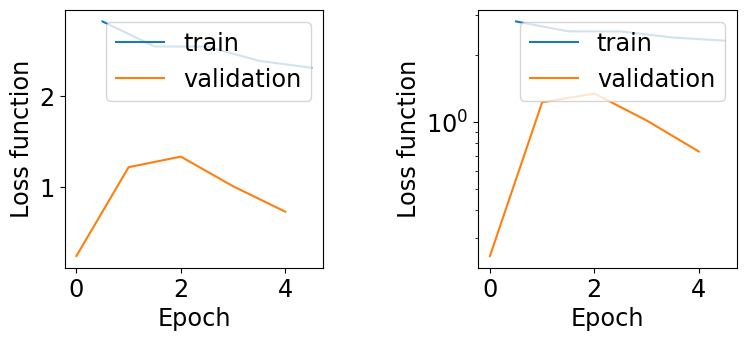

In [38]:
#BEGIN_SOLUTION
nEpochs = 5

initial_learning_rate = 5E-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*3,
                decay_rate=0.95,
                staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=tf.keras.losses.MeanAbsolutePercentageError(),
            metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=1E-3)
callbacks = [early_stop_callback]
    
history = model.fit(dataset_cached.skip(batchSize*4),
                    epochs=nEpochs, 
                    validation_data=dataset_cached.take(batchSize*4),
                    callbacks=callbacks,
                    verbose=1)

model.evaluate(dataset_cached.take(16))
plf.plotTrainHistory(history)

print(colored("Model weights:","blue"))
print(colored("output:","blue"), model.get_layer('output').weights[0].numpy()[:,0])
#END_SOLUTION
pass


5) oszacowanie wydajności modelu na danych testowych

In [39]:
#BEGIN_SOLUTION
dataset_test = dataset.batch(128).map(func).take(16)
y_pred = model.predict(dataset_test)
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])

pull = (y_pred - y)/y
pull = pull.flatten()
threshold = 1E-2

print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.2f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.2f}".format(pull.std()))
#END_SOLUTION
pass

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step


2024-05-08 14:44:23.898715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Fraction of examples with abs(pull)<0.01: 0.01
Pull standard deviation: 3.94


2024-05-08 14:44:26.713742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* rozwiązać problem z różnicą wyników na zbiorach treningowym i testowym
* narysować histogram różnicy względnej:

$$
{\huge
\mathrm{pull} = \frac{\mathrm{model} - \mathrm{true}}{\mathrm{true}}
}
$$

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step


2024-05-08 14:44:37.374550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 0.6561


2024-05-08 14:44:37.944226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-08 14:44:38.041816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-08 14:44:38.041837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Fraction of examples with abs(pull)<0.01: 0.8604
Pull standard deviation: 0.0149


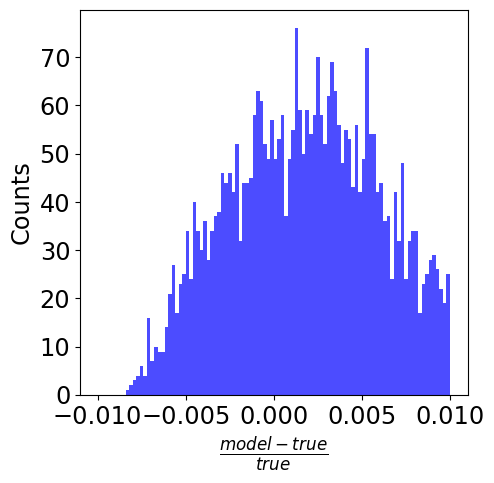

In [40]:
#BEGIN_SOLUTION
dataset_test = dataset.batch(128).map(func).take(32).cache()
y_pred = model.predict(dataset_test)
y = np.array([y.numpy() for x,y in dataset_test.unbatch()])

pull = (y_pred - y)/y
pull = pull.flatten()
threshold = 1E-2

fig, axis = plt.subplots(1,1, figsize=(5, 5))
axis.hist(pull, bins=100, range=(-0.01, 0.01), color='b', alpha=0.7, label='Pull');
axis.set_xlabel(r'$\frac{model-true}{true}$')
axis.set_ylabel('Counts')
model.evaluate(dataset_test)
print(colored("Fraction of examples with abs(pull)<0.01:","blue"),"{:3.4f}".format(np.mean(np.abs(pull)<threshold)))
print(colored("Pull standard deviation:","blue"),"{:3.4f}".format(pull.std()))
#END_SOLUTION
pass

## Zbiory danych w TensorFlow datasets

Środowisko TensorFlow dostarcza wygodnego iterfejsu użytkownika do dostępu do publicznych zbiorów danych (podobnie jak inne pakiety):
[TensorFlow Datasets](https://www.tensorflow.org/datasets).


In [41]:
import tensorflow_datasets as tfds

#Create a dataset builder object
mnist_builder = tfds.builder('mnist')

#Download the dataset as a dictionary of tf.data.Datasets
data_dir = "../data/tensorflow_datasets/"

datasets, ds_info = tfds.load("mnist", 
                              data_dir = data_dir,
                              with_info=True)

#Download the dataset as a tuple of tf.data.Datasets
#datasets, ds_info = tfds.load("mnist", as_supervised=True, with_info=True)

# Load data from disk as tf.data.Datasets
train_dataset, test_dataset = datasets['train'], datasets['test']

# Fetch the first batch of the dataset
item = next(iter(train_dataset.batch(16)))

print(colored("Features shape:", "blue"), item['image'].shape)
print(colored("Labels shape:", "blue"), item['label'].shape)


2024-05-08 14:45:16.916269: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Features shape: (16, 28, 28, 1)
Labels shape: (16,)


2024-05-08 14:45:18.076540: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Biblioteka `tensorflow_datasets` dostarcza użytecznej funkcji do testu  wydajności wczytytywania zbioru danych:

```Python
tfds.benchmark(train_dataset, # Obiekt który dostarcza interfejsu iteratora
                batch_size)   # Liczba służąca do normalizacji liczby wczytanych przykładów. 
                              # Podział na paczki trzeba ustawić na zbiorze explicite.
```

**Proszę:**

* uruchomić dwukrotnie test wydajności na zbiorze MNIST wczytanym z użyciem modułu `tensorflow_datasets` dla paczki o rozmiarze `32`

In [42]:
#BEGIN_SOLUTION
batchSize = 32
train_dataset_batched = train_dataset.batch(batchSize)

tfds.benchmark(train_dataset_batched, batch_size=batchSize)
tfds.benchmark(train_dataset_batched, batch_size=batchSize)
#END_SOLUTION
pass


************ Summary ************



  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 110446.48 ex/sec (total: 60032 ex, 0.54 sec)
Examples/sec (First only) 413.10 ex/sec (total: 32 ex, 0.08 sec)
Examples/sec (First excluded) 128734.08 ex/sec (total: 60000 ex, 0.47 sec)

************ Summary ************



2024-05-08 14:45:36.173863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1875 [00:00<?, ?it/s]

Examples/sec (First included) 263436.82 ex/sec (total: 60032 ex, 0.23 sec)
Examples/sec (First only) 2591.48 ex/sec (total: 32 ex, 0.01 sec)
Examples/sec (First excluded) 278381.05 ex/sec (total: 60000 ex, 0.22 sec)


2024-05-08 14:45:36.422416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Funkcja `tfds.show_examples(...)` pozwala na szybkie wyświetlenie przykładów z podanego zbioru.

**Uwaga:** funkcja wymaga obiektu `dataset_info.DatasetInfo`

2024-05-08 14:45:55.572804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


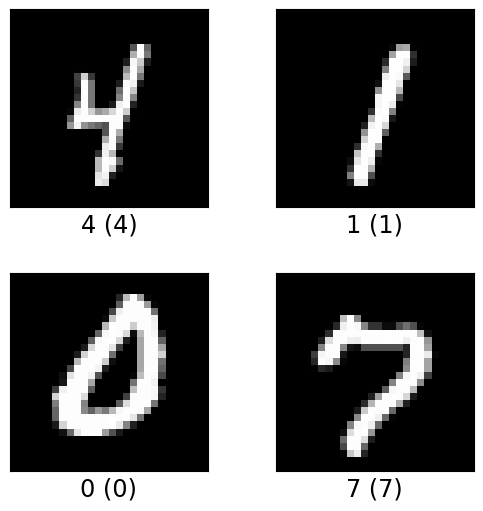

In [43]:
fig = tfds.show_examples(train_dataset, ds_info, rows=2, cols=2)

# Zadanie domowe

**Proszę:**

* napisać funkcję `load_wksf_dataset(filePath)` wczytującą i wstępnie przetwarzającą  zbiór fragmentów tekstow w języku [polskim](https://drive.google.com/drive/folders/18vDJPEZd2C6_-TualBIhsR5zmbhDA00D?usp=drive_link) pochodzący ze [Wzbogaconego korpusu słownika frekwencyjnego polszczyzny współczesnej](https://clarin-pl.eu/dspace/handle/11321/715)
* funkcja powinna wykonywać następujące kroki:
  * wczytuje wszystkie plików w katalogu podanym jako `filePath` do obiektu `tf.data.Dataset` 
  * przetwarza powstały obiekt by usunąć:
    * informację o źródle cytatu
    * odnośniki w tekście
    * fragmenty typu `[/]` 

* funkcję należy umieścić w pliku `text_functions.py`
 * uruchomić komórkę poniżej
 
**Wskazówka:**
* mozna użyć funkcji `tf.strings.regex_full_match(...)` oraz `tf.strings.regex_replace(...)` do filtrowania linii lub zastępowania
  fragmentów napisów
  

In [44]:
import text_functions as txtfunc
importlib.reload(txtfunc)

filePath = "../data/wksf/Korpus_surowy/"
dataset = txtfunc.load_wksf_dataset(filePath)

for item in dataset.take(5):
    print(colored("Item:","blue"), end=" ")
    print(item.numpy().decode("utf-8"))


Reading text from files: ['../data/wksf/Korpus_surowy/a-publi.txt', '../data/wksf/Korpus_surowy/b-prasa.txt', '../data/wksf/Korpus_surowy/d-proza.txt', '../data/wksf/Korpus_surowy/e-dramat.txt', '../data/wksf/Korpus_surowy/c-popul.txt']
Item: Sztuka utraciła swoją moc pobudzającą: przykrym widowiskiem staje się koncert wybitnej niegdyś śpiewaczki i nie uświetnią go nawet nigdy dotąd nie wykonywane utwory genialnego kompozytora. Słuchacze myślą o czym innym, rozmawiają o czym innym i śpiewaczka, postarzawszy się, głos straciła. Nie było dotąd takich koncertów u Iwaszkiewicza[/].
Item: Stosunek tych dwóch rodzajów mieszczan układa się tak, że solidny obywatel uważa egzystencję poety czy malarza za mocno wątpliwą, podejrzaną: ten zaś rewanżuje się pogardą i krytycznym stanowiskiem wobec „nieartystycznego” przedstawiciela klasy, z której sam wyszedł (ta wzajemna nieufność i niechęć zaznacza się już zresztą w [„]Buddenbrookach[”] porównaj postać Gerdy[/]).
Item: Wzrasta w stosunku do całej 

2024-05-08 14:46:35.677200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
